Cell 1: Import Libraries

In [1]:
# Import required libraries
import numpy as np
import random
import matplotlib.pyplot as plt
from kaggle_environments import make, evaluate
import time


No pygame installed, ignoring import


Cell 2: Define Game Logic (Base Model)

In [10]:
# The board size
ROW_COUNT = 6
COLUMN_COUNT = 7

def create_board():
    """Create a 6*7 board"""
    board = np.zeros((ROW_COUNT, COLUMN_COUNT))
    return board

def drop_piece(board, row, col, piece):
    """Places a piece on the board"""
    board[row][col] = piece

def is_valid_location(board, col):
    """Checks if the board is valid"""
    return board[ROW_COUNT - 1, col] == 0

def get_next_open_row(board, col):
    """Finds the next open row in the column"""
    for r in range(ROW_COUNT):
        if board[r][col] == 0:
            return r
        
def choose_winning_move(board, piece):
    """
    Check if any move that can make the agent win in this turn
    """
    for col in range(COLUMN_COUNT):
        if is_valid_location(board, col): 
            row = get_next_open_row(board, col) # get the lowest empty col
            temp_board = board.copy() # simulation 
            drop_piece(temp_board, row, col, piece)
            
            if winning_move(temp_board, piece):
                return col
            
    return None 

def block_rival_win(board, piece):
    """
    Check if a rival piece is going to win and block it
    """
    rival_piece = 2 if piece == 1 else 1
    
    for col in range(COLUMN_COUNT):
        if is_valid_location(board, col):
            row = get_next_open_row(board, col)
            temp_board = board.copy()
            drop_piece(temp_board, row, col, piece)
            
            if winning_move(temp_board, rival_piece):
                return col
    
    return None
            

def winning_move(board, piece):
    """Checks if a player has won"""
    # Check horizontal locations for win
    for c in range(COLUMN_COUNT - 3):
        for r in range(ROW_COUNT):
            if board[r][c] == piece and board[r][c + 1] == piece and board[r][c + 2] == piece and board[r][c + 3] == piece:
                return True

    # Check vertical locations for win
    for c in range(COLUMN_COUNT):
        for r in range(ROW_COUNT - 3):
            if board[r][c] == piece and board[r + 1][c] == piece and board[r + 2][c] == piece and board[r + 3][c] == piece:
                return True

    # Check diagonals
    for c in range(COLUMN_COUNT - 3):
        for r in range(ROW_COUNT - 3):
            if board[r][c] == piece and board[r + 1][c + 1] == piece and board[r + 2][c + 2] == piece and board[r + 3][c + 3] == piece:
                return True

    for c in range(COLUMN_COUNT - 3):
        for r in range(3, ROW_COUNT):
            if board[r][c] == piece and board[r - 1][c + 1] == piece and board[r - 2][c + 2] == piece and board[r - 3][c + 3] == piece:
                return True


Cell 3: Visualization for Local Environment

In [11]:
import matplotlib.pyplot as plt
import numpy as np

def draw_board(board):
    """Draws the board using matplotlib and shows player numbers on pieces"""
    # Draw the board as it is, without flipping
    plt.imshow(board, cmap='coolwarm', interpolation='nearest')
    
    # Loop through each position in the board
    for r in range(ROW_COUNT):
        for c in range(COLUMN_COUNT):
            piece = board[r][c]
            if piece != 0:
                # Add text for player number in the center of the piece
                plt.text(c, r, int(piece), ha='center', va='center', color='white', fontsize=20, fontweight='bold')

    plt.title('Connect 4 Board')
    plt.xticks(range(COLUMN_COUNT))
    plt.yticks(range(ROW_COUNT))
    plt.gca().invert_yaxis()  # Ensure the pieces stack from the bottom up
    plt.show(block=False)
    plt.pause(0.1)
    
def print_board(board):
    """Flips the board so the bottom row is at the bottom when visualizing"""
    print(np.flip(board, 0))


Create Agent

In [12]:
# Agent 2.0
def agent_with_win_check(board, piece):
    """
    Our 2.0 agent that not only make random move, but it will check first are he have any chance to win in that turn or not
    """
    
    winning_move_col = choose_winning_move(board, piece)
    
    if winning_move_col is None:
        return random.choice([col for col in range(COLUMN_COUNT)])
    
    return winning_move_col

# Agent 3.0
def agent_with_win_and_block_check(board, piece):
    """
    The 3.0 agent that will check winning move, and can cehck if it needs to block the rival
    """
    
    # check if our agent can win
    winning_move_col = choose_winning_move(board, piece)
    
    if winning_move_col:
        return winning_move_col
    
    # check the rival about to win and block it
    block_col = block_rival_win(board, piece)
    
    if block_col:
        return block_col
    
    valid_cols = [col for col in range(COLUMN_COUNT) if is_valid_location(board, col)]
    return random.choice(valid_cols)

Cell 4: Local Game Simulation

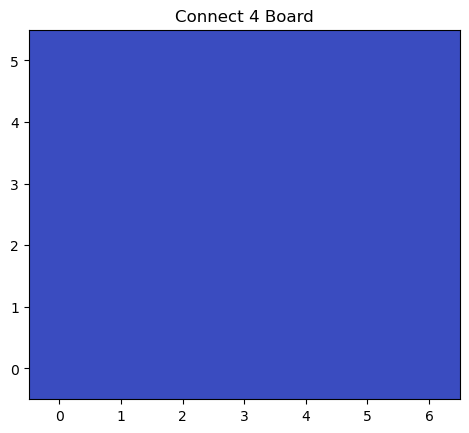

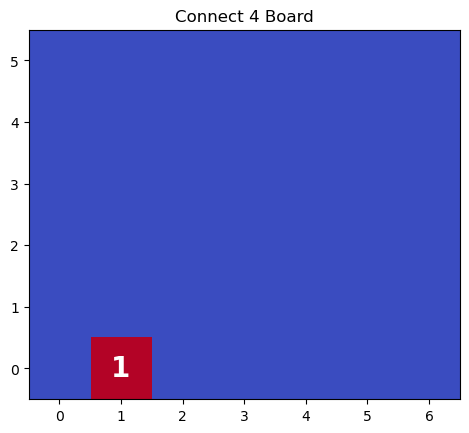

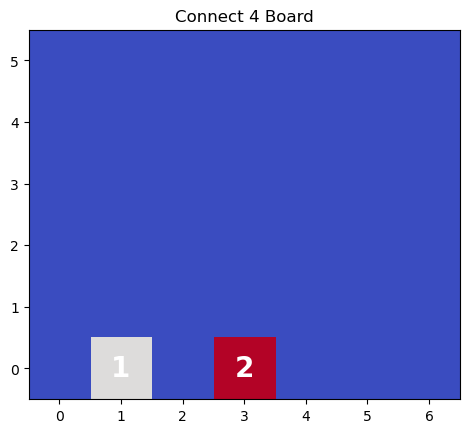

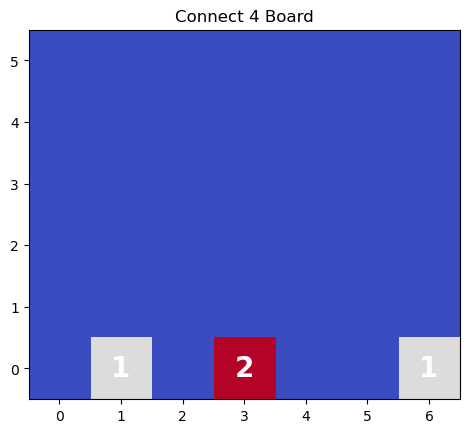

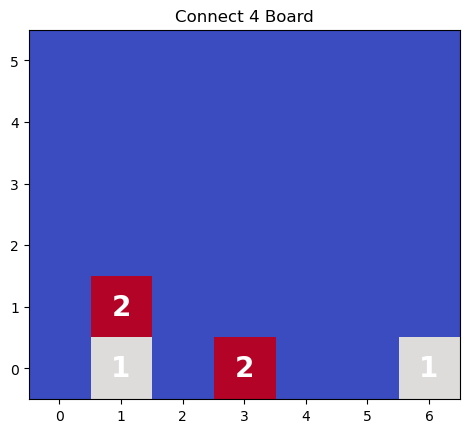

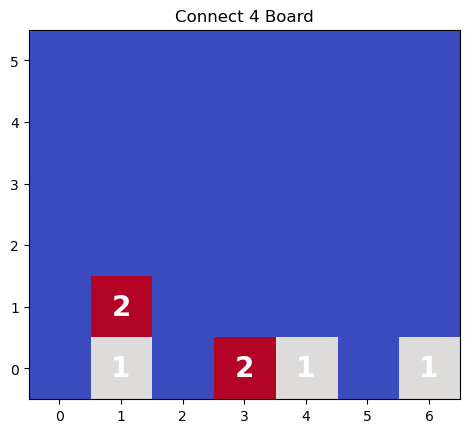

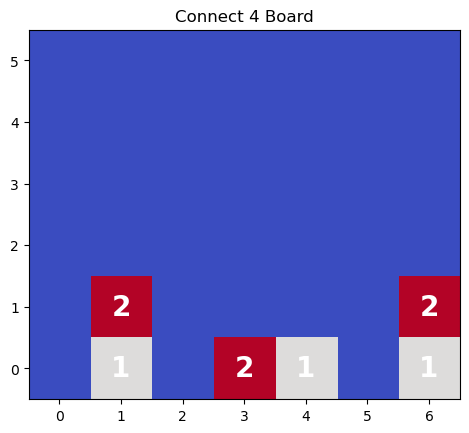

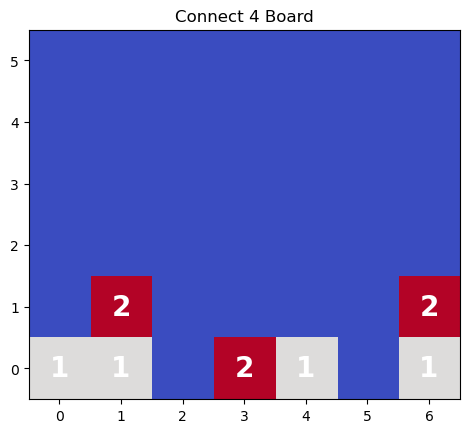

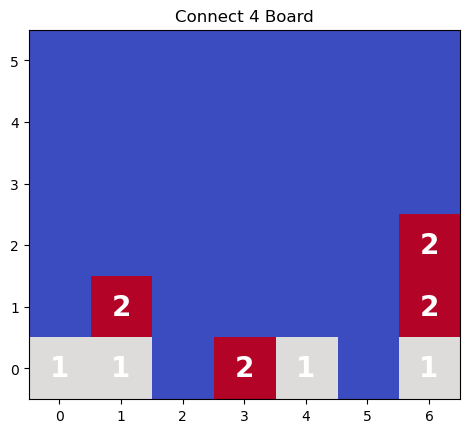

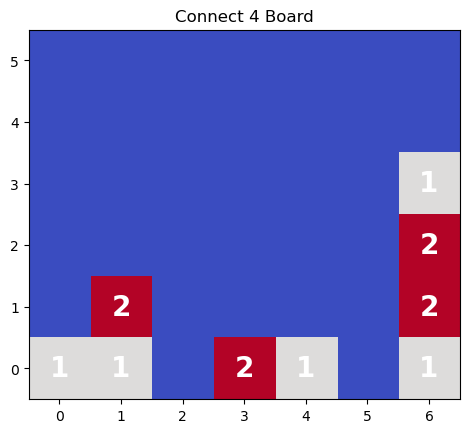

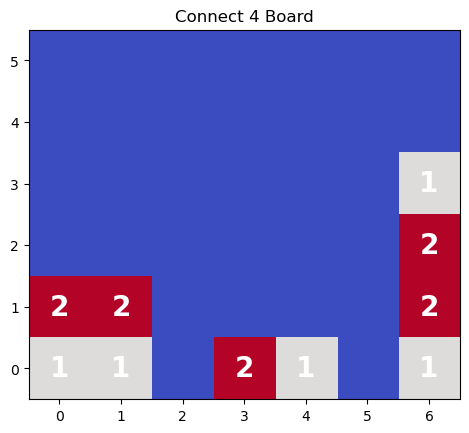

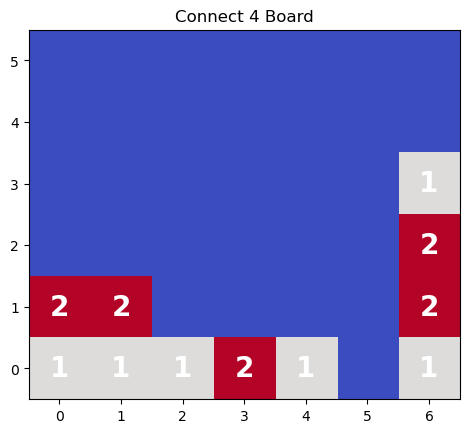

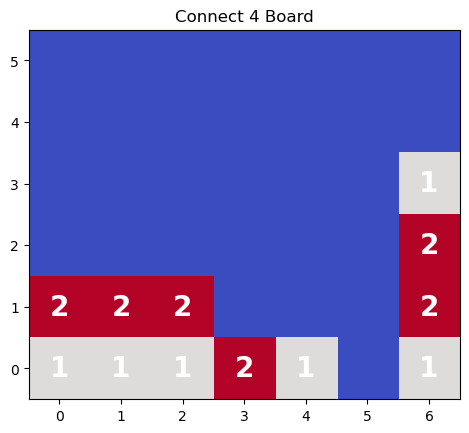

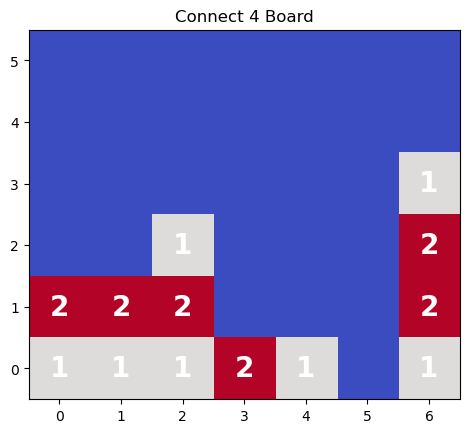

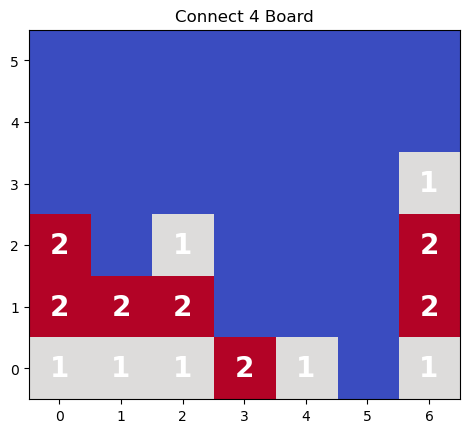

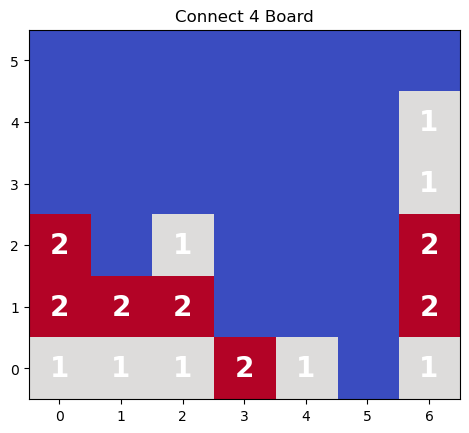

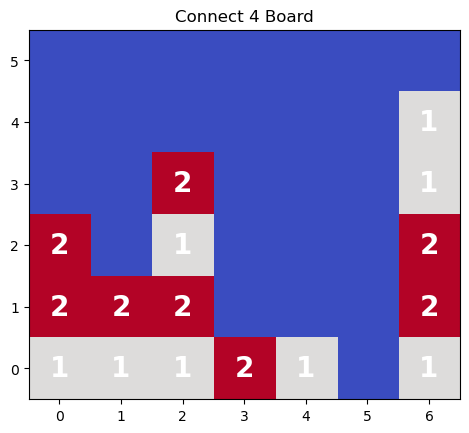

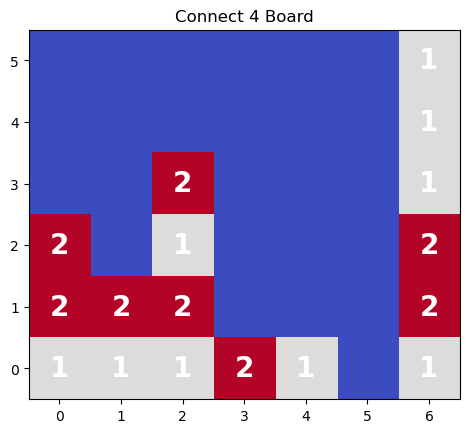

Player 2 wins!
[[0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 2. 0. 0. 0. 1.]
 [2. 0. 1. 0. 0. 0. 2.]
 [2. 2. 2. 2. 0. 0. 2.]
 [1. 1. 1. 2. 1. 0. 1.]]


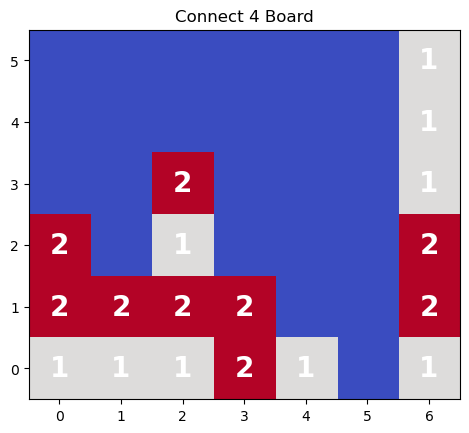

In [14]:
def play_game_local():
    """Main function for local simulation"""
    
    board = create_board()
    game_over = False
    turn = 0

    while not game_over:
        draw_board(board)  
        time.sleep(1) 
        
        # Agent 1 with smarter logic
        if turn == 0:
            col = agent_with_win_and_block_check(board, turn + 1)
        else:
            col = random.randint(0, COLUMN_COUNT - 1) # base agent 2
        
        if is_valid_location(board, col):
            row = get_next_open_row(board, col)
            drop_piece(board, row, col, turn + 1)
            
            if winning_move(board, turn + 1):
                print(f"Player {turn + 1} wins!")
                game_over = True

        turn += 1
        turn = turn % 2

    print_board(board)
    draw_board(board)

# Uncomment to play a local game
play_game_local()

Cell 5: Kaggle Agent Logic

In [10]:
# Kaggle environment setup
env = make("connectx", debug=True)

def kaggle_agent(obs, conf):
    """A sample agent for ConnectX in Kaggle"""
    valid_moves = [col for col in range(conf.columns) if obs.board[col] == 0]
    return random.choice(valid_moves)


Cell 6: Play Game in Kaggle Environment

In [15]:
def play_game_kaggle():
    """Play game in Kaggle environment"""
    env.render()
    trainer = env.train([None, "negamax"])  # Use Negamax agent as the opponent
    observation = trainer.reset()
    while not env.done:
        action = kaggle_agent(observation, env.configuration)
        observation, reward, done, info = trainer.step(action)
        env.render()
        

# Uncomment to play in Kaggle environment
play_game_kaggle()


Cell 7: Training and Evaluation in Kaggle Environment

In [12]:
def mean_reward(rewards):
    return "won {0} of {1}".format(sum(r[0] for r in rewards), len(rewards))

# Run multiple episodes to estimate its performance.
print("My Agent vs Random Agent:", mean_reward(evaluate("connectx", [kaggle_agent, "random"], num_episodes=10)))
print("My Agent vs Negamax Agent:", mean_reward(evaluate("connectx", [kaggle_agent, "negamax"], num_episodes=10)))


My Agent vs Random Agent: won 0 of 10
My Agent vs Negamax Agent: won -10 of 10
